In [211]:
# import plumed
import matplotlib.pyplot as plt
import os
# import MDAnalysis

In [212]:
# set working directory for all future cells
os.chdir("/home/lammps/plumed/PRL-2017-PairEntropy/Project/Proj23")
# and check with bash command pwd - note the exclamation mark at the beginning
!pwd
# or in python
os.getcwd()

/home/lammps/plumed/PRL-2017-PairEntropy/Project/Proj23


'/home/lammps/plumed/PRL-2017-PairEntropy/Project/Proj23'

In [245]:
%%bash
cat > "in.partitions" << EOF
    variable p_id world   0 # 1 2 3 4 5
EOF

cat > "in.temp" << EOF
    variable temperature equal \${tmp}
    variable tempDamp equal 0.1 # approx 0.1 ps
EOF

cat > "in.pressure" << EOF
    variable pressure equal 1.
    variable pressureDamp equal 10.0
EOF

cat > "in.seed" << EOF
    variable seed world 74581 # 93734 12832 21934 57383 49172
EOF

cat > "in.box" << EOF
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 \${side} 0 \${side} 0 \${side}
    create_box      1 box
    create_atoms    1 random \${numAtoms} \${seed} box
    mass            1 \${mass}
    change_box      all triclinic
EOF

cat > "in.na" << EOF
    ### Argon Potential Parameters ###
    pair_style  eam/fs
    pair_coeff  * * Na_MendelevM_2014.eam.fs Na
EOF


cat > "in.setup" << EOF
    variable        out_freq equal 500
    variable        out_freq2 equal 25000
    neigh_modify    delay 10 every 1
    include         in.na
    timestep        0.002 # According to Frenkel and Smit is 0.001
    thermo          \${out_freq}
    thermo_style    custom step temp pe ke press density vol enthalpy atoms lx ly lz xy xz yz pxx pyy pzz pxy pxz pyz
    restart         \${out_freq2} restart/restart.\${temperature}.\${p_id} #restart2.\${p_id}
EOF

cat > "in.dump" << EOF
    dump         myDump all atom \${out_freq2} dump.350.\${p_id}
    dump_modify  myDump append yes
EOF

# NVT
### we preform an NVT integration: 
First an energy minimization procedure is applied, adjusting the atoms coordinates until one of these stopping criteria is met:
The change in energy between two iterations is less than 1.0e-4,
- The change in energy between two iterations is less than 1.0e-4,
- The maximum force between two atoms in the system is lower than 1.0e-6,
- The maximum number of iterations is 1000,
- The maximum number of times the force and the energy have been evaluated is 10000.

Next, we perform a temperature adjustment using a canonical sampling thermostat. the thermostat is similar to the empirical Berendsen thermostat in temp/berendsen, but chooses the actual scaling factor from a suitably chosen (gaussian) distribution rather than having it determined from the time constant directly.

Unlike the fix nvt command which performs Nose/Hoover thermostatting and time integration, these fixes do not perform time integration. They only modify velocities to effect thermostatting. Thus we must use a separate time integration fix, the fix nve to actually update the positions of atoms using the modified velocities. the velocities are updated using a random number generator at the chosen temprature.

In [214]:
%%bash
cat > "start_temp.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
include in.box
include in.setup

minimize 1.0e-2 1.0e-3 100 1000
reset_timestep 0

# NVT
variable kenergy equal ke
variable penergy equal pe
variable pres equal press
variable tempera equal temp
variable dense equal density
variable entha equal enthalpy 

fix myat1 all ave/time 10 1 10 v_kenergy v_penergy v_pres v_tempera v_dense v_entha file data/temp/energy\${temperature}.dat


fix             1 all nve
fix             2 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}

velocity        all create \${temperature} \${seed} dist gaussian
run             25000

unfix           2
run             5000
unfix           1

# neigh_modify every 1 delay 5 check yes

EOF


In [215]:
import subprocess

for temp in range(300,401,25):
    cmd = f"lmp -v tmp {temp} -in start_temp.lmp"
    results = subprocess.run(cmd, shell=True, universal_newlines=True, check=True)

LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 300
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
include in.box
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 ${side} 0 ${side} 0 ${side}
    region          box block 0 22 0 ${side} 0 ${side}
    region          box block 0 22 0 22 0 ${side}
    region          box block 0 22 0 22 0 22
    create_box      1 box
Created orthogonal box = (0

   11000    294.63378   -258.66665    9.4830169   -2149.1045   0.89630466        10648   -263.46649      250           22           22           22            0            0            0   -1893.8218   -2059.6367   -2493.8549    89.634694    -22.84652   -253.43707 
   11500     296.5795    -258.6702    9.5456413   -2467.6002   0.89630466        10648   -265.52413      250           22           22           22            0            0            0   -2459.2532   -2691.1254   -2252.4219    61.688184    133.86173   -282.99233 
   12000    292.88457   -258.63418    9.4267173   -2170.1342   0.89630466        10648   -263.63009      250           22           22           22            0            0            0    -2452.073   -2406.2529   -1652.0766   -204.42904    421.98725   -142.93489 
   12500    309.90882   -259.22657    9.9746558   -2416.3305   0.89630466        10648   -265.31075      250           22           22           22            0            0            0   -3212.1571   

Neigh   | 0.4061     | 0.4061     | 0.4061     |   0.0 |  4.34
Comm    | 0.10285    | 0.10285    | 0.10285    |   0.0 |  1.10
Output  | 0.0014497  | 0.0014497  | 0.0014497  |   0.0 |  0.02
Modify  | 0.098153   | 0.098153   | 0.098153   |   0.0 |  1.05
Other   |            | 0.02898    |            |       |  0.31

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1796.00 ave        1796 max        1796 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17333.0 ave       17333 max       17333 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17333
Ave neighs/atom = 69.332000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 574
Dangerous builds = 0

unfix           2
run             5000
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 25000
  Time step     : 0.002
Per MPI rank memory allocation (min/avg/max) = 6.354 | 6.354 | 6.354 Mbytes
Step Temp PotEng KinEng Press Density Volume Enthalpy Atom

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.011868   | 0.011868   | 0.011868   |   0.0 | 78.42
Bond    | 2.209e-06  | 2.209e-06  | 2.209e-06  |   0.0 |  0.01
Neigh   | 0.0026645  | 0.0026645  | 0.0026645  |   0.0 | 17.61
Comm    | 0.00023791 | 0.00023791 | 0.00023791 |   0.0 |  1.57
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0003608  |            |       |  2.38

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

   11000    328.81493   -257.87446    10.583164    -2048.469   0.89630466        10648   -260.90534      250           22           22           22            0            0            0   -2310.8578    -1639.949   -2194.6001     284.4169    268.69316    104.82821 
   11500    311.31918   -257.48746    10.020049   -2054.7049   0.89630466        10648    -261.1229      250           22           22           22            0            0            0   -2510.9106   -1480.5984   -2172.6058    262.97105   -195.61877   -403.21815 
   12000    340.47063   -258.31334    10.958312    -2150.144   0.89630466        10648    -261.6448      250           22           22           22            0            0            0   -2013.9523   -2269.1997   -2167.2801   -101.03204    220.34679   -90.980014 
   12500    320.12159    -257.5412    10.303362   -1997.2845   0.89630466        10648   -260.51171      250           22           22           22            0            0            0   -1677.8347   

Neigh   | 0.45514    | 0.45514    | 0.45514    |   0.0 |  5.01
Comm    | 0.10607    | 0.10607    | 0.10607    |   0.0 |  1.17
Output  | 0.0013592  | 0.0013592  | 0.0013592  |   0.0 |  0.01
Modify  | 0.095634   | 0.095634   | 0.095634   |   0.0 |  1.05
Other   |            | 0.02949    |            |       |  0.32

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1826.00 ave        1826 max        1826 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17335.0 ave       17335 max       17335 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17335
Ave neighs/atom = 69.340000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 600
Dangerous builds = 0

unfix           2
run             5000
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 25000
  Time step     : 0.002
Per MPI rank memory allocation (min/avg/max) = 6.354 | 6.354 | 6.354 Mbytes
Step Temp PotEng KinEng Press Density Volume Enthalpy Atom

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.011916   | 0.011916   | 0.011916   |   0.0 | 78.90
Bond    | 1.949e-06  | 1.949e-06  | 1.949e-06  |   0.0 |  0.01
Neigh   | 0.0026111  | 0.0026111  | 0.0026111  |   0.0 | 17.29
Comm    | 0.00023382 | 0.00023382 | 0.00023382 |   0.0 |  1.55
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0003398  |            |       |  2.25

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

   11000    341.64449   -257.14955    10.996093    -1785.243   0.89630466        10648   -258.01811      250           22           22           22            0            0            0   -2031.3281   -1499.7557   -1824.6451    33.099295   -176.52788   -72.389616 
   11500    341.22994   -256.97028    10.982751   -1802.0583   0.89630466        10648   -257.96394      250           22           22           22            0            0            0   -1462.4652   -1983.8504   -1959.8592   -430.00704   -395.85703    265.98786 
   12000    368.95384   -257.27669    11.875066   -1874.1059   0.89630466        10648   -257.85686      250           22           22           22            0            0            0   -2381.5707   -1934.0786   -1306.6682    78.484461   -763.62664    114.22875 
   12500    374.45826   -257.35628     12.05223   -1877.0677   0.89630466        10648   -257.77896      250           22           22           22            0            0            0   -2192.4365   

Neigh   | 0.43299    | 0.43299    | 0.43299    |   0.0 |  5.11
Comm    | 0.10058    | 0.10058    | 0.10058    |   0.0 |  1.19
Output  | 0.0018968  | 0.0018968  | 0.0018968  |   0.0 |  0.02
Modify  | 0.085605   | 0.085605   | 0.085605   |   0.0 |  1.01
Other   |            | 0.02771    |            |       |  0.33

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1828.00 ave        1828 max        1828 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17296.0 ave       17296 max       17296 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17296
Ave neighs/atom = 69.184000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 623
Dangerous builds = 0

unfix           2
run             5000
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 25000
  Time step     : 0.002
Per MPI rank memory allocation (min/avg/max) = 6.354 | 6.354 | 6.354 Mbytes
Step Temp PotEng KinEng Press Density Volume Enthalpy Atom

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.012675   | 0.012675   | 0.012675   |   0.0 | 79.75
Bond    | 1.777e-06  | 1.777e-06  | 1.777e-06  |   0.0 |  0.01
Neigh   | 0.0026106  | 0.0026106  | 0.0026106  |   0.0 | 16.43
Comm    | 0.0002417  | 0.0002417  | 0.0002417  |   0.0 |  1.52
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0003648  |            |       |  2.30

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

   11000     351.2183   -254.56886    11.304234   -986.93613   0.89630466        10648   -249.82376      250           22           22           22            0            0            0   -1065.3905   -1311.9524   -583.46543    214.73129    137.00346   -62.264425 
   11500    386.38711   -256.70304    12.436169    -1509.358   0.89630466        10648     -254.298      250           22           22           22            0            0            0   -1288.3276   -2013.9718   -1225.7745   -633.83268    313.80961   -511.05567 
   12000    383.27521   -256.02476     12.33601   -1298.2809   0.89630466        10648   -252.31707      250           22           22           22            0            0            0   -995.63524   -1556.9991   -1342.2084   -79.080309   -1.4239213    403.29483 
   12500    399.41961   -256.14456     12.85563   -1399.4877   0.89630466        10648   -252.58987      250           22           22           22            0            0            0   -2523.3483   

Neigh   | 0.45308    | 0.45308    | 0.45308    |   0.0 |  5.27
Comm    | 0.10148    | 0.10148    | 0.10148    |   0.0 |  1.18
Output  | 0.0031345  | 0.0031345  | 0.0031345  |   0.0 |  0.04
Modify  | 0.086027   | 0.086027   | 0.086027   |   0.0 |  1.00
Other   |            | 0.027      |            |       |  0.31

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1790.00 ave        1790 max        1790 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17317.0 ave       17317 max       17317 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17317
Ave neighs/atom = 69.268000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 644
Dangerous builds = 0

unfix           2
run             5000
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 25000
  Time step     : 0.002
Per MPI rank memory allocation (min/avg/max) = 6.354 | 6.354 | 6.354 Mbytes
Step Temp PotEng KinEng Press Density Volume Enthalpy Atom

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.013193   | 0.013193   | 0.013193   |   0.0 | 78.04
Bond    | 2.142e-06  | 2.142e-06  | 2.142e-06  |   0.0 |  0.01
Neigh   | 0.002977   | 0.002977   | 0.002977   |   0.0 | 17.61
Comm    | 0.00029309 | 0.00029309 | 0.00029309 |   0.0 |  1.73
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0004402  |            |       |  2.60

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

   11000    377.90182   -254.08274    12.163063   -766.98163   0.89630466        10648     -247.017      250           22           22           22            0            0            0   -576.79672   -992.47147   -731.67671   -414.16202    -888.3542   -203.09928 
   11500    385.78137   -254.52472    12.416673   -611.86319   0.89630466        10648   -246.17446      250           22           22           22            0            0            0    -519.6378    -479.3571   -836.59468    139.02114    110.47626    95.634813 
   12000    414.73111   -255.22444    13.348443   -1023.2675   0.89630466        10648   -248.67659      250           22           22           22            0            0            0   -199.10951   -1517.9192   -1352.7738    118.69283    30.471517    614.86176 
   12500    393.08783   -254.69041    12.651837    -1011.131   0.89630466        10648    -248.7585      250           22           22           22            0            0            0   -1084.0564   

Neigh   | 0.46552    | 0.46552    | 0.46552    |   0.0 |  5.40
Comm    | 0.10261    | 0.10261    | 0.10261    |   0.0 |  1.19
Output  | 0.0010725  | 0.0010725  | 0.0010725  |   0.0 |  0.01
Modify  | 0.083784   | 0.083784   | 0.083784   |   0.0 |  0.97
Other   |            | 0.02895    |            |       |  0.34

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1810.00 ave        1810 max        1810 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17307.0 ave       17307 max       17307 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17307
Ave neighs/atom = 69.228000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 668
Dangerous builds = 0

unfix           2
run             5000
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 25000
  Time step     : 0.002
Per MPI rank memory allocation (min/avg/max) = 6.354 | 6.354 | 6.354 Mbytes
Step Temp PotEng KinEng Press Density Volume Enthalpy Atom

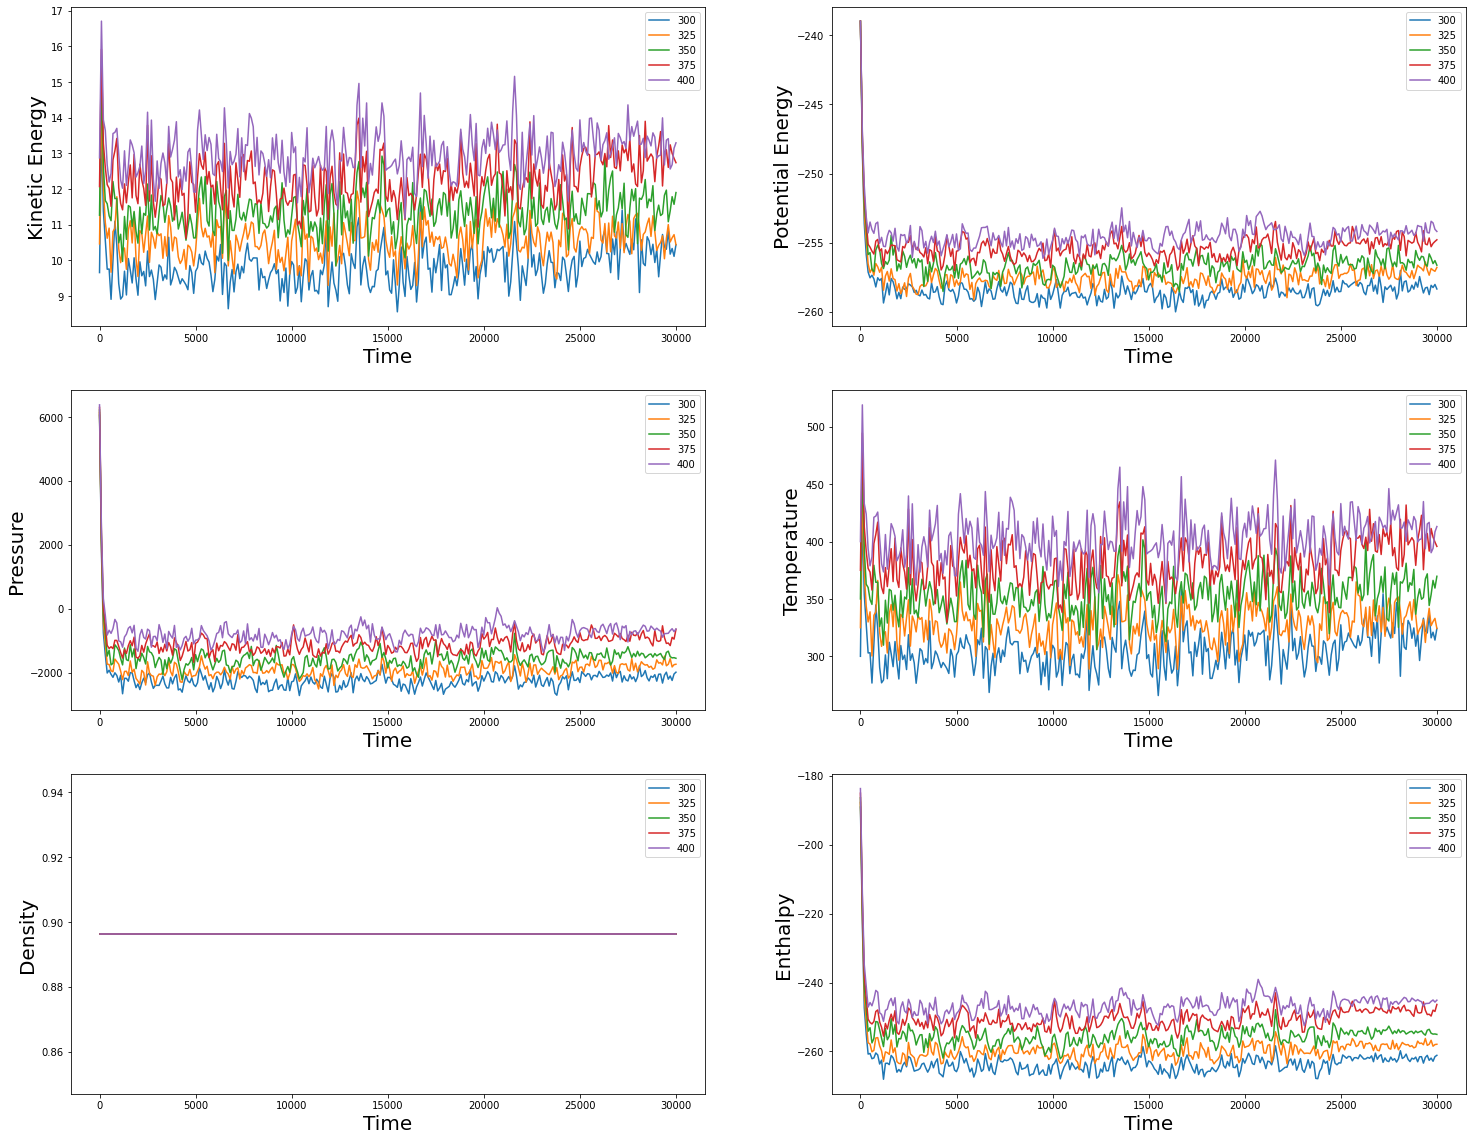

In [228]:
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = ['Kinetic Energy', 'Potential Energy', 'Pressure', 'Temperature', 'Density', 'Enthalpy']
temperatures = range(300,401,25)
fontsize = 20
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}

energy = {}
for tmp in temperatures:
    energy[tmp] = np.loadtxt('data/temp/energy{}.dat'.format(tmp)) # ke, pe, press, temp, dense, natoms

fig = plt.figure(figsize=(25, 20))
for n,label in enumerate(labels):
    ax = fig.add_subplot(3,2,n+1)
    for tmp in temperatures:
        plt.plot((energy[tmp].T[0][::10]), energy[tmp].T[n+1][::10], label=tmp)
    ax.set_xlabel('Time', fontdict=font)
    ax.set_ylabel(label, fontdict=font)
    ax.legend()

plt.show()



In [227]:
energy[tmp].T[0][0]

0.0

# NVT-2
A different NVT integration can be done using the Nose-Hoover style non-Hamiltonian equations of motion, 
sampling from an isenthalpic ensemble (at a speicific enthalpy). This is done by fixing a desired pressure value over which a time scale factor of relaxation pressure, pressureDamp is defined.
if pdamp is too small, pressure can oscilate widely. if pdamp is too big the system will take a long time to equilibrate.
Temperature is adjusted using a canonical sampling thermostat that uses global velocity rescaling.

In [222]:
%%bash
cat > "start_press.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
include in.box
include in.setup

minimize 1.0e-2 1.0e-3 100 1000
reset_timestep 0

# NVT
variable kenergy equal ke
variable penergy equal pe
variable pres equal press
variable tempera equal temp
variable dense equal density
variable entha equal enthalpy 

fix myat1 all ave/time 10 1 10 v_kenergy v_penergy v_pres v_tempera v_dense v_entha file data/press/energy\${temperature}.dat


fix             1 all nph iso \${pressure} \${pressure} \${pressureDamp}
fix             2 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}

velocity        all create \${temperature} \${seed} dist gaussian
run             25000

unfix           1
unfix           2

fix             3 all nve
run             5000
unfix           3

# neigh_modify every 1 delay 5 check yes

EOF


In [223]:
import subprocess

for temp in range(300,401,25):
    cmd = f"lmp -v tmp {temp} -in start_press.lmp"
    results = subprocess.run(cmd, shell=True, universal_newlines=True, check=True)

LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 300
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
include in.box
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 ${side} 0 ${side} 0 ${side}
    region          box block 0 22 0 ${side} 0 ${side}
    region          box block 0 22 0 22 0 ${side}
    region          box block 0 22 0 22 0 22
    create_box      1 box
Created orthogonal box = (0

   10500    280.18577   -267.37386    9.0179964   -151.23421    0.9545838    9997.9195    -259.2996      250    21.542853    21.542853    21.542853            0            0            0   -304.55942    38.176321   -187.31954    167.51965    130.10014    305.52808 
   11000    305.24479   -267.47738    9.8245404    531.88687   0.96387426    9901.5529   -254.36574      250    21.473414    21.473414    21.473414            0            0            0    636.34494    521.45861    437.85705    294.33976    127.83868    129.89278 
   11500     298.6457    -267.3569    9.6121435    139.84716   0.96051833    9936.1476   -256.87747      250    21.498394    21.498394    21.498394            0            0            0    239.28802   -37.390332    217.64378    382.76228    48.939886    230.41792 
   12000    319.34719   -267.79711    10.278437    -392.3471   0.95130164    10032.414   -259.97544      250      21.5676      21.5676      21.5676            0            0            0   -192.65835   

---------------------------------------------------------------
Pair    | 8.1631     | 8.1631     | 8.1631     |   0.0 | 91.56
Bond    | 0.0017627  | 0.0017627  | 0.0017627  |   0.0 |  0.02
Neigh   | 0.41601    | 0.41601    | 0.41601    |   0.0 |  4.67
Comm    | 0.10716    | 0.10716    | 0.10716    |   0.0 |  1.20
Output  | 0.0012369  | 0.0012369  | 0.0012369  |   0.0 |  0.01
Modify  | 0.19718    | 0.19718    | 0.19718    |   0.0 |  2.21
Other   |            | 0.02958    |            |       |  0.33

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1924.00 ave        1924 max        1924 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        18787.0 ave       18787 max       18787 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 18787
Ave neighs/atom = 75.148000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 565
Dangerous builds = 0

unfix           1
unfix           2

fix             3 all nve
run             50

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.014134   | 0.014134   | 0.014134   |   0.0 | 78.47
Bond    | 2.978e-06  | 2.978e-06  | 2.978e-06  |   0.0 |  0.02
Neigh   | 0.0031791  | 0.0031791  | 0.0031791  |   0.0 | 17.65
Comm    | 0.00028159 | 0.00028159 | 0.00028159 |   0.0 |  1.56
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0004147  |            |       |  2.30

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

   10500    295.39904   -258.88338    9.5076472   -304.86853    0.9264748    10301.254    -251.3359      250    21.758554    21.758554    21.758554            0            0            0   -505.95305   -341.22798   -67.424556    167.06348    457.60872    128.90741 
   11000    314.11974   -259.10341    10.110188   -559.52558   0.92148972    10356.982   -252.61017      250     21.79772     21.79772     21.79772            0            0            0   -604.64774   -1001.4211   -72.507872   -14.306766    64.010146    37.347467 
   11500    327.83692   -259.42672    10.551686    -299.3442   0.93013916    10260.671   -250.79209      250    21.729943    21.729943    21.729943            0            0            0    -1323.984    -664.9159    1090.8673   -561.46777    21.564328   -570.86301 
   12000    321.25034   -259.54257    10.339691    604.30332   0.94170368    10134.666   -245.38032      250    21.640625    21.640625    21.640625            0            0            0   -102.86697   

---------------------------------------------------------------
Pair    | 8.1609     | 8.1609     | 8.1609     |   0.0 | 91.95
Bond    | 0.0013209  | 0.0013209  | 0.0013209  |   0.0 |  0.01
Neigh   | 0.41201    | 0.41201    | 0.41201    |   0.0 |  4.64
Comm    | 0.098674   | 0.098674   | 0.098674   |   0.0 |  1.11
Output  | 0.0011721  | 0.0011721  | 0.0011721  |   0.0 |  0.01
Modify  | 0.17138    | 0.17138    | 0.17138    |   0.0 |  1.93
Other   |            | 0.02951    |            |       |  0.33

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1882.00 ave        1882 max        1882 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        18159.0 ave       18159 max       18159 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 18159
Ave neighs/atom = 72.636000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 590
Dangerous builds = 0

unfix           1
unfix           2

fix             3 all nve
run             50

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.011776   | 0.011776   | 0.011776   |   0.0 | 78.36
Bond    | 1.853e-06  | 1.853e-06  | 1.853e-06  |   0.0 |  0.01
Neigh   | 0.0026358  | 0.0026358  | 0.0026358  |   0.0 | 17.54
Comm    | 0.00023347 | 0.00023347 | 0.00023347 |   0.0 |  1.55
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0003806  |            |       |  2.53

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

   10500     341.7423   -258.77512    10.999241   -48.255989   0.92758258    10288.951   -248.08577      250    21.749889    21.749889    21.749889            0            0            0   -139.38582    370.17758   -375.55973    228.53566   -219.91244   -651.42807 
   11000    326.48378   -257.44101    10.508134   -142.55592   0.92042514    10368.961   -247.85547      250    21.806121    21.806121    21.806121            0            0            0   -234.66275   -1073.2985    880.29351     230.0336   -137.91814   -314.79401 
   11500     341.4966   -257.83173    10.991333    -392.7934   0.92037446    10369.531   -249.38262      250    21.806521    21.806521    21.806521            0            0            0    -896.7452    113.68145   -395.31646   -369.15363   -274.48582   -420.82933 
   12000    363.40254    -258.7285    11.696393    143.69477   0.92806041    10283.654    -246.1098      250    21.746155    21.746155    21.746155            0            0            0     89.59926   

---------------------------------------------------------------
Pair    | 8.1275     | 8.1275     | 8.1275     |   0.0 | 91.36
Bond    | 0.0018216  | 0.0018216  | 0.0018216  |   0.0 |  0.02
Neigh   | 0.44348    | 0.44348    | 0.44348    |   0.0 |  4.98
Comm    | 0.10346    | 0.10346    | 0.10346    |   0.0 |  1.16
Output  | 0.0012039  | 0.0012039  | 0.0012039  |   0.0 |  0.01
Modify  | 0.18805    | 0.18805    | 0.18805    |   0.0 |  2.11
Other   |            | 0.03095    |            |       |  0.35

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1842.00 ave        1842 max        1842 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17828.0 ave       17828 max       17828 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17828
Ave neighs/atom = 71.312000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 623
Dangerous builds = 0

unfix           1
unfix           2

fix             3 all nve
run             50

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.012663   | 0.012663   | 0.012663   |   0.0 | 76.55
Bond    | 1.991e-06  | 1.991e-06  | 1.991e-06  |   0.0 |  0.01
Neigh   | 0.0031736  | 0.0031736  | 0.0031736  |   0.0 | 19.18
Comm    | 0.00025608 | 0.00025608 | 0.00025608 |   0.0 |  1.55
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0004483  |            |       |  2.71

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

   10500    375.48388   -258.52817     12.08524    275.62191   0.93076192    10253.806   -244.67897      250    21.725096    21.725096    21.725096            0            0            0    335.81423    164.29039     326.7611    243.74148    -333.1635   -364.49005 
   11000    363.36216   -257.06274    11.695093    121.97947   0.92381703     10330.89   -244.58112      250      21.7794      21.7794      21.7794            0            0            0   -697.97782    305.07476    758.84146   -467.62508  -0.72630855    373.30093 
   11500    392.74442   -257.71852    12.640784    -475.4552   0.91463102    10434.647   -248.17428      250     21.85207     21.85207     21.85207            0            0            0   -539.66652   -557.12183   -329.57725     35.04414   -441.20226   -176.16273 
   12000    384.54447   -257.18052    12.376862   -474.66407   0.91304986    10452.717    -247.9004      250    21.864677    21.864677    21.864677            0            0            0   -1181.6833   

---------------------------------------------------------------
Pair    | 8.1252     | 8.1252     | 8.1252     |   0.0 | 91.31
Bond    | 0.0014213  | 0.0014213  | 0.0014213  |   0.0 |  0.02
Neigh   | 0.45461    | 0.45461    | 0.45461    |   0.0 |  5.11
Comm    | 0.10441    | 0.10441    | 0.10441    |   0.0 |  1.17
Output  | 0.0012828  | 0.0012828  | 0.0012828  |   0.0 |  0.01
Modify  | 0.18241    | 0.18241    | 0.18241    |   0.0 |  2.05
Other   |            | 0.02888    |            |       |  0.32

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1834.00 ave        1834 max        1834 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17717.0 ave       17717 max       17717 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17717
Ave neighs/atom = 70.868000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 645
Dangerous builds = 0

unfix           1
unfix           2

fix             3 all nve
run             50

  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.011764   | 0.011764   | 0.011764   |   0.0 | 78.21
Bond    | 1.94e-06   | 1.94e-06   | 1.94e-06   |   0.0 |  0.01
Neigh   | 0.0026979  | 0.0026979  | 0.0026979  |   0.0 | 17.94
Comm    | 0.00023938 | 0.00023938 | 0.00023938 |   0.0 |  1.59
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0003379  |            |       |  2.25

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17

   10500    397.20314    -256.3404    12.784291    285.48351   0.92210275    10350.096   -241.71188      250    21.792888    21.792888    21.792888            0            0            0     26.16012    114.93218    715.35823    76.273563   -251.23642   -30.958013 
   11000     379.5576   -255.41374    12.216356    408.19137   0.91998324    10373.941   -240.55439      250    21.809611    21.809611    21.809611            0            0            0    -121.9376    70.700087    1275.8116    128.20997    151.57597   -385.77076 
   11500    399.83632   -255.34294    12.869042    14.875241   0.91108945    10475.209   -242.37664      250    21.880348    21.880348    21.880348            0            0            0   -298.86275   -9.0974238    352.58589    186.82476    -98.22251   -266.85511 
   12000    415.89965   -255.74711    13.386053   -573.84128   0.90345061    10563.778   -246.14462      250    21.941842    21.941842    21.941842            0            0            0   -867.00075   

---------------------------------------------------------------
Pair    | 8.1148     | 8.1148     | 8.1148     |   0.0 | 91.28
Bond    | 0.0014575  | 0.0014575  | 0.0014575  |   0.0 |  0.02
Neigh   | 0.46126    | 0.46126    | 0.46126    |   0.0 |  5.19
Comm    | 0.10264    | 0.10264    | 0.10264    |   0.0 |  1.15
Output  | 0.001198   | 0.001198   | 0.001198   |   0.0 |  0.01
Modify  | 0.17999    | 0.17999    | 0.17999    |   0.0 |  2.02
Other   |            | 0.02881    |            |       |  0.32

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1822.00 ave        1822 max        1822 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17669.0 ave       17669 max       17669 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17669
Ave neighs/atom = 70.676000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 669
Dangerous builds = 0

unfix           1
unfix           2

fix             3 all nve
run             50

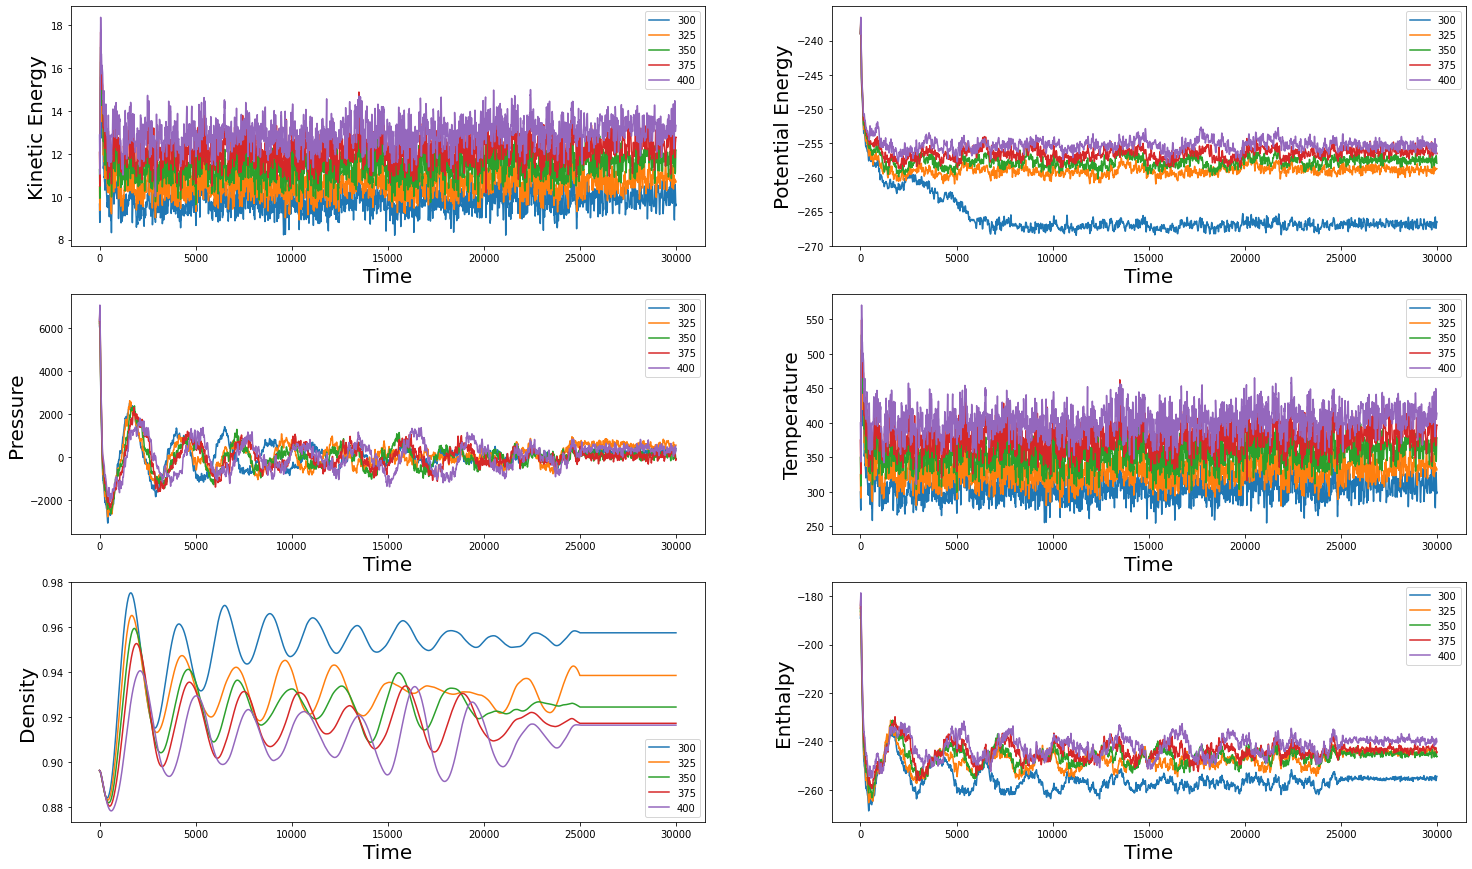

In [229]:
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = ['Kinetic Energy', 'Potential Energy', 'Pressure', 'Temperature', 'Density', 'Enthalpy']
temperatures = range(300,401,25)
fontsize = 20
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}

energy = {}
for tmp in temperatures:
    energy[tmp] = np.loadtxt('data/press/energy{}.dat'.format(tmp)) # ke, pe, press, temp, dense, natoms

fig = plt.figure(figsize=(25, 15))
for n,label in enumerate(labels):
    ax = fig.add_subplot(3,2,n+1)
    for tmp in temperatures:
        plt.plot((energy[tmp].T[0][:]), energy[tmp].T[n+1][:], label=tmp)
    ax.set_xlabel('Time', fontdict=font)
    ax.set_ylabel(label, fontdict=font)
    ax.legend()

plt.show()



# NVT + NPH
The article use both methods to reach equilibration

In [236]:
%%bash
cat > "start_temp_press.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
include in.box
include in.setup

minimize 1.0e-2 1.0e-3 100 1000
reset_timestep 0

# NVT
variable kenergy equal ke
variable penergy equal pe
variable pres equal press
variable tempera equal temp
variable dense equal density
variable entha equal enthalpy 

fix myat1 all ave/time 10 1 10 v_kenergy v_penergy v_pres v_tempera v_dense v_entha file data/temp_press/energy\${temperature}.dat


fix             1 all nve
fix             2 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}

velocity        all create \${temperature} \${seed} dist gaussian
run             25000

unfix           1
unfix           2

fix             1 all nph iso \${pressure} \${pressure} \${pressureDamp}
fix             2 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}

velocity        all create \${temperature} \${seed} dist gaussian
run             25000

unfix           1
unfix           2

fix             1 all nve
run             5000
unfix           1

# neigh_modify every 1 delay 5 check yes

EOF

In [237]:
import subprocess

for temp in range(300,401,25):
    cmd = f"lmp -v tmp {temp} -in start_temp_press.lmp"
    results = subprocess.run(cmd, shell=True, universal_newlines=True, check=True)

LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 300
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
include in.box
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 ${side} 0 ${side} 0 ${side}
    region          box block 0 22 0 ${side} 0 ${side}
    region          box block 0 22 0 22 0 ${side}
    region          box block 0 22 0 22 0 22
    create_box      1 box
Created orthogonal box = (0

   10500    277.21411   -258.80025    8.9223513   -2410.1816   0.89630466        10648   -265.89587      250           22           22           22            0            0            0   -2124.8606   -2271.0554   -2834.6287    499.54799    16.992529    342.23902 
   11000    294.63378   -258.66665    9.4830169   -2149.1045   0.89630466        10648   -263.46649      250           22           22           22            0            0            0   -1893.8218   -2059.6367   -2493.8549    89.634694    -22.84652   -253.43707 
   11500     296.5795    -258.6702    9.5456413   -2467.6002   0.89630466        10648   -265.52413      250           22           22           22            0            0            0   -2459.2532   -2691.1254   -2252.4219    61.688184    133.86173   -282.99233 
   12000    292.88457   -258.63418    9.4267173   -2170.1342   0.89630466        10648   -263.63009      250           22           22           22            0            0            0    -2452.073   

Bond    | 0.0029713  | 0.0029713  | 0.0029713  |   0.0 |  0.02
Neigh   | 0.58823    | 0.58823    | 0.58823    |   0.0 |  4.37
Comm    | 0.18897    | 0.18897    | 0.18897    |   0.0 |  1.41
Output  | 0.0019761  | 0.0019761  | 0.0019761  |   0.0 |  0.01
Modify  | 0.22297    | 0.22297    | 0.22297    |   0.0 |  1.66
Other   |            | 0.04674    |            |       |  0.35

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1796.00 ave        1796 max        1796 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17333.0 ave       17333 max       17333 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17333
Ave neighs/atom = 69.332000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 574
Dangerous builds = 0

unfix           1
unfix           2

fix             1 all nph iso ${pressure} ${pressure} ${pressureDamp}
fix             1 all nph iso 1 ${pressure} ${pressureDamp}
fix             1 all nph iso 1 1 ${press

   36500    297.41649   -260.42951    9.5725806    197.72143   0.94071857    10145.279   -249.60492      250    21.648177    21.648177    21.648177            0            0            0    732.85759    -37.42097   -102.27233    44.299899   -160.70769    -586.4722 
   37000     307.6976   -260.65725    9.9034861   -158.11568    0.9360299    10196.097      -251.76      250    21.684263    21.684263    21.684263            0            0            0    -101.7056   -136.74901   -235.89242    239.63688   -163.69219   -228.13781 
   37500    293.16582   -260.01368    9.4357693   -203.67541    0.9342226    10215.822   -251.87659      250    21.698237    21.698237    21.698237            0            0            0   -15.892686   -440.22107   -154.91248   -280.10428   -81.741069   -110.41498 
   38000    310.49063   -260.60194    9.9933818    23.461446    0.9385759    10168.439   -250.45966      250    21.664638    21.664638    21.664638            0            0            0    443.22154   

Neighs:        17910.0 ave       17910 max       17910 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17910
Ave neighs/atom = 71.640000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 564
Dangerous builds = 0

unfix           1
unfix           2

fix             1 all nve
run             5000
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 50000
  Time step     : 0.002
Per MPI rank memory allocation (min/avg/max) = 6.354 | 6.354 | 6.354 Mbytes
Step Temp PotEng KinEng Press Density Volume Enthalpy Atoms Lx Ly Lz Xy Xz Yz Pxx Pyy Pzz Pxy Pxz Pyz 
   50000    303.90754   -259.57706       9.7815   -609.79882   0.92539717     10313.25   -253.72085      250    21.766997    21.766997    21.766997            0            0            0   -581.52961   -469.12573   -778.74111    155.69142    132.50208   -716.45292 
   50500    307.25518   -259.68489    9.8892466   -745.27359   0.92539717     10313.25   -254.59299      250    21.766997    21.766997    21

  Force max component initial, final = 10406.104 0.37951929
  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.022914   | 0.022914   | 0.022914   |   0.0 | 76.18
Bond    | 5.885e-06  | 5.885e-06  | 5.885e-06  |   0.0 |  0.02
Neigh   | 0.0059355  | 0.0059355  | 0.0059355  |   0.0 | 19.73
Comm    | 0.00047756 | 0.00047756 | 0.00047756 |   0.0 |  1.59
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0007478  |            |       |  2.49

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 m

   10500     300.1065   -257.80722    9.6591606   -2206.7623   0.89630466        10648   -262.81412      250           22           22           22            0            0            0     -1719.74   -2154.3341   -2746.2129   -188.78848    60.413123   -518.97964 
   11000    328.81493   -257.87446    10.583164    -2048.469   0.89630466        10648   -260.90534      250           22           22           22            0            0            0   -2310.8578    -1639.949   -2194.6001     284.4169    268.69316    104.82821 
   11500    311.31918   -257.48746    10.020049   -2054.7049   0.89630466        10648    -261.1229      250           22           22           22            0            0            0   -2510.9106   -1480.5984   -2172.6058    262.97105   -195.61877   -403.21815 
   12000    340.47063   -258.31334    10.958312    -2150.144   0.89630466        10648    -261.6448      250           22           22           22            0            0            0   -2013.9523   

Bond    | 0.0062966  | 0.0062966  | 0.0062966  |   0.0 |  0.04
Neigh   | 0.67649    | 0.67649    | 0.67649    |   0.0 |  4.72
Comm    | 0.18014    | 0.18014    | 0.18014    |   0.0 |  1.26
Output  | 0.0041312  | 0.0041312  | 0.0041312  |   0.0 |  0.03
Modify  | 0.21696    | 0.21696    | 0.21696    |   0.0 |  1.51
Other   |            | 0.05207    |            |       |  0.36

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1826.00 ave        1826 max        1826 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17335.0 ave       17335 max       17335 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17335
Ave neighs/atom = 69.340000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 600
Dangerous builds = 0

unfix           1
unfix           2

fix             1 all nph iso ${pressure} ${pressure} ${pressureDamp}
fix             1 all nph iso 1 ${pressure} ${pressureDamp}
fix             1 all nph iso 1 1 ${press

   36500    318.02327   -259.80233    10.235826    831.70929   0.94637374    10084.654   -244.33144      250     21.60497     21.60497     21.60497            0            0            0    40.027399    1087.2499    1367.8505   -405.74673   -434.02981   -76.818582 
   37000    333.37732   -259.45612    10.730008    704.63945   0.94327454    10117.788   -244.27629      250    21.628606    21.628606    21.628606            0            0            0   -175.33725    1394.3873    894.86825   -47.150743     253.7096   -234.31372 
   37500     320.7697    -258.8316    10.324222   -405.71859   0.92326387    10337.079   -251.12503      250    21.783749    21.783749    21.783749            0            0            0   -764.87759    103.09524   -555.37342    541.98834      437.893     690.1336 
   38000     312.5903   -257.59404    10.060961   -762.73047   0.91523537    10427.757   -252.49731      250    21.847259    21.847259    21.847259            0            0            0    74.621844   

Neighs:        18064.0 ave       18064 max       18064 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 18064
Ave neighs/atom = 72.256000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 594
Dangerous builds = 0

unfix           1
unfix           2

fix             1 all nve
run             5000
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 50000
  Time step     : 0.002
Per MPI rank memory allocation (min/avg/max) = 6.354 | 6.354 | 6.354 Mbytes
Step Temp PotEng KinEng Press Density Volume Enthalpy Atoms Lx Ly Lz Xy Xz Yz Pxx Pyy Pzz Pxy Pxz Pyz 
   50000    329.56823   -258.90872    10.607409    65.083877   0.93229273    10236.969   -247.88547      250    21.713198    21.713198    21.713198            0            0            0     458.6837   -600.04467     336.6126    138.48464    267.49555    29.711769 
   50500    314.11595   -258.41126    10.110066    144.97836   0.93229273    10236.969   -247.37487      250    21.713198    21.713198    21

  Force max component initial, final = 10406.104 0.37951929
  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.01775    | 0.01775    | 0.01775    |   0.0 | 78.59
Bond    | 3.698e-06  | 3.698e-06  | 3.698e-06  |   0.0 |  0.02
Neigh   | 0.0040308  | 0.0040308  | 0.0040308  |   0.0 | 17.85
Comm    | 0.00033534 | 0.00033534 | 0.00033534 |   0.0 |  1.48
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.0004653  |            |       |  2.06

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 m

   10500    325.54693   -257.87394    10.477981   -2099.2436   0.89630466        10648   -261.34744      250           22           22           22            0            0            0   -2483.7927   -1692.1617   -2121.7765   -329.15653    481.73064    172.48395 
   11000    341.64449   -257.14955    10.996093    -1785.243   0.89630466        10648   -258.01811      250           22           22           22            0            0            0   -2031.3281   -1499.7557   -1824.6451    33.099295   -176.52788   -72.389616 
   11500    341.22994   -256.97028    10.982751   -1802.0583   0.89630466        10648   -257.96394      250           22           22           22            0            0            0   -1462.4652   -1983.8504   -1959.8592   -430.00704   -395.85703    265.98786 
   12000    368.95384   -257.27669    11.875066   -1874.1059   0.89630466        10648   -257.85686      250           22           22           22            0            0            0   -2381.5707   

Bond    | 0.0030704  | 0.0030704  | 0.0030704  |   0.0 |  0.02
Neigh   | 0.67743    | 0.67743    | 0.67743    |   0.0 |  4.87
Comm    | 0.17101    | 0.17101    | 0.17101    |   0.0 |  1.23
Output  | 0.0023161  | 0.0023161  | 0.0023161  |   0.0 |  0.02
Modify  | 0.20186    | 0.20186    | 0.20186    |   0.0 |  1.45
Other   |            | 0.05218    |            |       |  0.38

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1828.00 ave        1828 max        1828 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17296.0 ave       17296 max       17296 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17296
Ave neighs/atom = 69.184000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 623
Dangerous builds = 0

unfix           1
unfix           2

fix             1 all nph iso ${pressure} ${pressure} ${pressureDamp}
fix             1 all nph iso 1 ${pressure} ${pressureDamp}
fix             1 all nph iso 1 1 ${press

   36500    344.59264   -257.65229    11.090982   -220.48055   0.92397695    10329.102   -247.98273      250    21.778143    21.778143    21.778143            0            0            0   -484.60141   -726.02054    549.18031   -243.36199    258.47961   -424.26782 
   37000    373.71878   -258.94124    12.028429    737.52061   0.93545024    10202.415   -242.21639      250    21.688741    21.688741    21.688741            0            0            0    1043.1803    1089.5279    79.853639    190.86353   -55.429913    3.6688273 
   37500    367.36163    -258.7759    11.823819    458.39199   0.93446677    10213.153   -244.03004      250    21.696347    21.696347    21.696347            0            0            0   -8.2738554     593.9643    789.48553    266.58529    766.97105     238.7411 
   38000    352.07645   -257.15842    11.331854    96.549513   0.92369562    10332.248   -245.20393      250    21.780354    21.780354    21.780354            0            0            0    219.65656   

Neighs:        17833.0 ave       17833 max       17833 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17833
Ave neighs/atom = 71.332000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 617
Dangerous builds = 0

unfix           1
unfix           2

fix             1 all nve
run             5000
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 50000
  Time step     : 0.002
Per MPI rank memory allocation (min/avg/max) = 6.354 | 6.354 | 6.354 Mbytes
Step Temp PotEng KinEng Press Density Volume Enthalpy Atoms Lx Ly Lz Xy Xz Yz Pxx Pyy Pzz Pxy Pxz Pyz 
   50000     359.8631   -257.42661    11.582473   -65.879446   0.92309698    10338.948   -246.26926      250    21.785061    21.785061    21.785061            0            0            0    158.99588   -512.58328    155.94906      -315.46    439.70815     291.5067 
   50500    353.86026   -257.23331    11.389267    108.65706   0.92309698    10338.948   -245.14287      250    21.785061    21.785061    21

  Force max component initial, final = 10406.104 0.37951929
  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.055047   | 0.055047   | 0.055047   |   0.0 | 87.00
Bond    | 6.582e-06  | 6.582e-06  | 6.582e-06  |   0.0 |  0.01
Neigh   | 0.0052783  | 0.0052783  | 0.0052783  |   0.0 |  8.34
Comm    | 0.00055379 | 0.00055379 | 0.00055379 |   0.0 |  0.88
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.002388   |            |       |  3.77

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 m

   10500    341.55402   -255.65156    10.993181   -1270.1553   0.89630466        10648   -253.09978      250           22           22           22            0            0            0   -1280.8954   -1491.0646    -1038.506   -395.19676   -251.15198   -294.98651 
   11000     351.2183   -254.56886    11.304234   -986.93613   0.89630466        10648   -249.82376      250           22           22           22            0            0            0   -1065.3905   -1311.9524   -583.46543    214.73129    137.00346   -62.264425 
   11500    386.38711   -256.70304    12.436169    -1509.358   0.89630466        10648     -254.298      250           22           22           22            0            0            0   -1288.3276   -2013.9718   -1225.7745   -633.83268    313.80961   -511.05567 
   12000    383.27521   -256.02476     12.33601   -1298.2809   0.89630466        10648   -252.31707      250           22           22           22            0            0            0   -995.63524   

Bond    | 0.0027938  | 0.0027938  | 0.0027938  |   0.0 |  0.02
Neigh   | 0.60357    | 0.60357    | 0.60357    |   0.0 |  5.03
Comm    | 0.15747    | 0.15747    | 0.15747    |   0.0 |  1.31
Output  | 0.0030105  | 0.0030105  | 0.0030105  |   0.0 |  0.03
Modify  | 0.16802    | 0.16802    | 0.16802    |   0.0 |  1.40
Other   |            | 0.0411     |            |       |  0.34

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1790.00 ave        1790 max        1790 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17317.0 ave       17317 max       17317 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17317
Ave neighs/atom = 69.268000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 644
Dangerous builds = 0

unfix           1
unfix           2

fix             1 all nph iso ${pressure} ${pressure} ${pressureDamp}
fix             1 all nph iso 1 ${pressure} ${pressureDamp}
fix             1 all nph iso 1 1 ${press

   36500    363.61322   -256.51477    11.703174   -293.91982   0.91305024    10452.713   -246.72915      250    21.864674    21.864674    21.864674            0            0            0   -225.52291   -237.58764   -418.64891   -201.05329    47.645842   -193.42063 
   37000    362.02392    -255.5221    11.652021    179.30494   0.91610714    10417.834   -242.70418      250    21.840327    21.840327    21.840327            0            0            0   -321.11875    722.79202    136.24155   -3.9382468    54.510403    278.68391 
   37500    389.26461    -257.3084    12.528784   -178.80178   0.91925058    10382.209   -245.93827      250    21.815404    21.815404    21.815404            0            0            0    485.50215   -872.60108   -149.30641   -341.37409    296.78375    479.14149 
   38000    362.18358   -256.11242     11.65716    390.69472   0.92210085    10350.117   -241.93136      250    21.792903    21.792903    21.792903            0            0            0    28.073355   

Neighs:        17829.0 ave       17829 max       17829 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17829
Ave neighs/atom = 71.316000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 652
Dangerous builds = 0

unfix           1
unfix           2

fix             1 all nve
run             5000
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 50000
  Time step     : 0.002
Per MPI rank memory allocation (min/avg/max) = 6.354 | 6.354 | 6.354 Mbytes
Step Temp PotEng KinEng Press Density Volume Enthalpy Atoms Lx Ly Lz Xy Xz Yz Pxx Pyy Pzz Pxy Pxz Pyz 
   50000    400.59978   -257.24956    12.893615    277.02205   0.92411663    10327.541   -242.57028      250    21.777046    21.777046    21.777046            0            0            0   -12.964352    581.82743    262.20306    89.773984   -113.64355    162.95478 
   50500    377.06613   -256.49212    12.136166    470.86834   0.92411663    10327.541   -241.32076      250    21.777046    21.777046    21

  Force max component initial, final = 10406.104 0.37951929
  Final line search alpha, max atom move = 0.24669475 0.093625417
  Iterations, force evaluations = 32 33

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 0.021732   | 0.021732   | 0.021732   |   0.0 | 77.83
Bond    | 3.156e-06  | 3.156e-06  | 3.156e-06  |   0.0 |  0.01
Neigh   | 0.0043317  | 0.0043317  | 0.0043317  |   0.0 | 15.51
Comm    | 0.00031891 | 0.00031891 | 0.00031891 |   0.0 |  1.14
Output  | 0          | 0          | 0          |   0.0 |  0.00
Modify  | 0          | 0          | 0          |   0.0 |  0.00
Other   |            | 0.001536   |            |       |  5.50

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1794.00 ave        1794 max        1794 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17089.0 ave       17089 max       17089 m

   10500    369.68829    -254.7106    11.898705   -734.13658   0.89630466        10648   -247.69094      250           22           22           22            0            0            0   -1232.1072   -722.15486   -248.14772    166.65383   -230.63549   -524.81094 
   11000    377.90182   -254.08274    12.163063   -766.98163   0.89630466        10648     -247.017      250           22           22           22            0            0            0   -576.79672   -992.47147   -731.67671   -414.16202    -888.3542   -203.09928 
   11500    385.78137   -254.52472    12.416673   -611.86319   0.89630466        10648   -246.17446      250           22           22           22            0            0            0    -519.6378    -479.3571   -836.59468    139.02114    110.47626    95.634813 
   12000    414.73111   -255.22444    13.348443   -1023.2675   0.89630466        10648   -248.67659      250           22           22           22            0            0            0   -199.10951   

Bond    | 0.0024222  | 0.0024222  | 0.0024222  |   0.0 |  0.02
Neigh   | 0.69385    | 0.69385    | 0.69385    |   0.0 |  5.06
Comm    | 0.1631     | 0.1631     | 0.1631     |   0.0 |  1.19
Output  | 0.0034637  | 0.0034637  | 0.0034637  |   0.0 |  0.03
Modify  | 0.17821    | 0.17821    | 0.17821    |   0.0 |  1.30
Other   |            | 0.05421    |            |       |  0.40

Nlocal:        250.000 ave         250 max         250 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:        1810.00 ave        1810 max        1810 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:        17307.0 ave       17307 max       17307 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17307
Ave neighs/atom = 69.228000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 668
Dangerous builds = 0

unfix           1
unfix           2

fix             1 all nph iso ${pressure} ${pressure} ${pressureDamp}
fix             1 all nph iso 1 ${pressure} ${pressureDamp}
fix             1 all nph iso 1 1 ${press

   36500    394.14816   -255.68222    12.685964   -564.72808   0.90689882    10523.613   -246.70558      250    21.913998    21.913998    21.913998            0            0            0    -945.3046   -622.62256   -126.25708    397.12787    309.65538   -101.26284 
   37000    423.21996   -255.50982    13.621663   -733.69467   0.90140673    10587.731   -246.73666      250    21.958414    21.958414    21.958414            0            0            0   -1208.5349   -25.975081   -966.57405   -252.36418    38.669468    -251.4003 
   37500    385.62402   -254.40916    12.411608   -221.37683   0.90627688    10530.835   -243.45262      250     21.91901     21.91901     21.91901            0            0            0   -512.98464    19.522733    -170.6686   -405.18489   -249.30559   -130.33329 
   38000    396.22588   -255.18985    12.752838    96.541722   0.91632843    10415.318   -241.80942      250    21.838569    21.838569    21.838569            0            0            0    266.11768   

Neighs:        17685.0 ave       17685 max       17685 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 17685
Ave neighs/atom = 70.740000
Ave special neighs/atom = 0.0000000
Neighbor list builds = 676
Dangerous builds = 0

unfix           1
unfix           2

fix             1 all nve
run             5000
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 50000
  Time step     : 0.002
Per MPI rank memory allocation (min/avg/max) = 6.354 | 6.354 | 6.354 Mbytes
Step Temp PotEng KinEng Press Density Volume Enthalpy Atoms Lx Ly Lz Xy Xz Yz Pxx Pyy Pzz Pxy Pxz Pyz 
   50000    405.49819   -255.07354    13.051274    324.68156   0.91622857    10416.453   -239.91137      250    21.839362    21.839362    21.839362            0            0            0   -89.479577    757.43201    306.09225    140.61094    149.11992    650.35393 
   50500    406.44195   -255.10364     13.08165    275.60001   0.91622857    10416.453    -240.2302      250    21.839362    21.839362    21

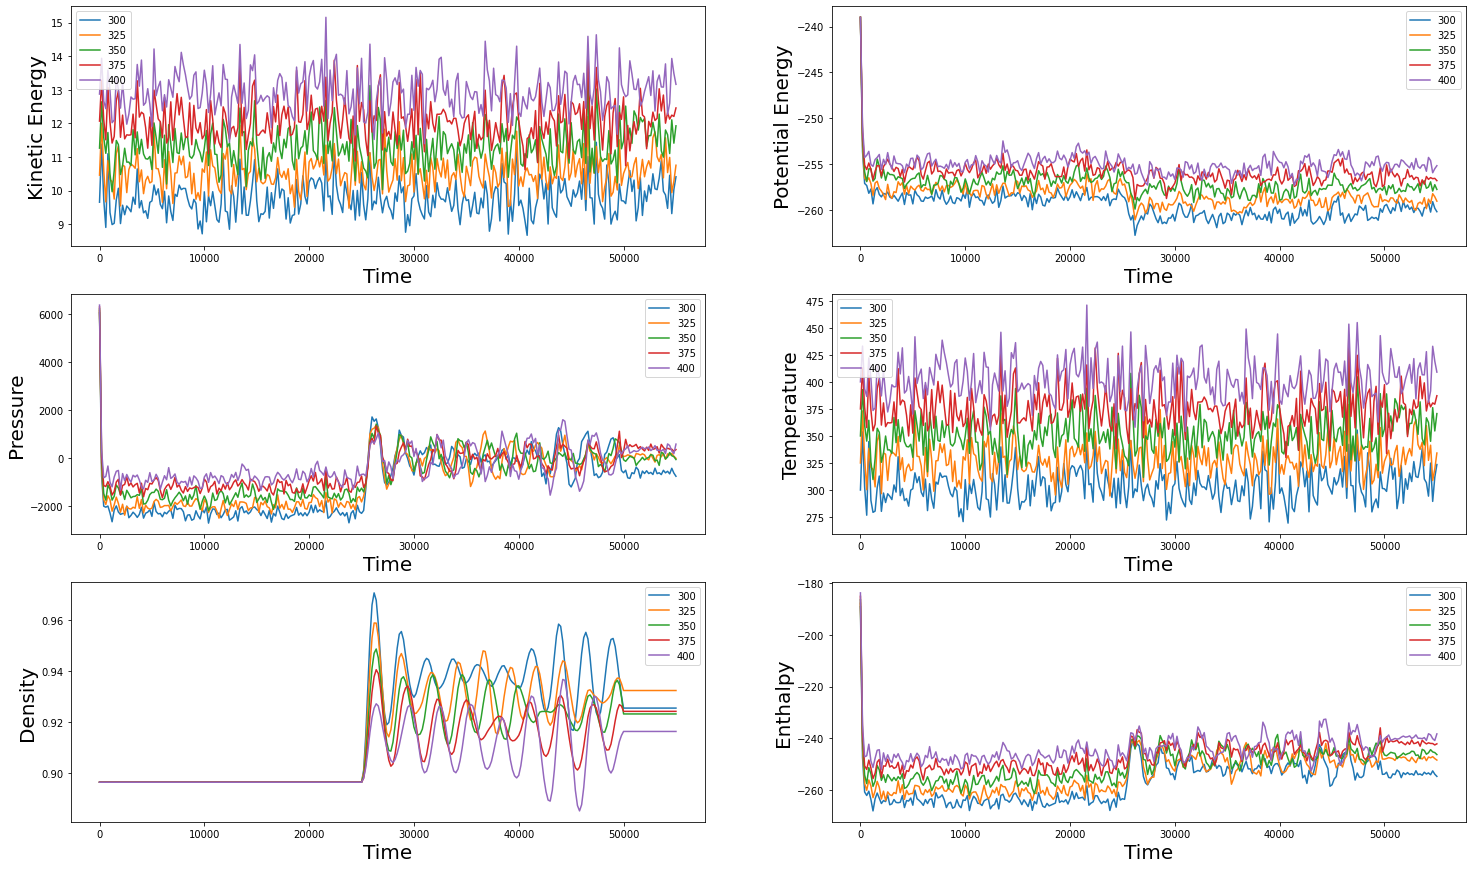

In [230]:
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = ['Kinetic Energy', 'Potential Energy', 'Pressure', 'Temperature', 'Density', 'Enthalpy']
temperatures = range(300,401,25)
fontsize = 20
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}

energy = {}
for tmp in temperatures:
    energy[tmp] = np.loadtxt('data/temp_press/energy{}.dat'.format(tmp)) # ke, pe, press, temp, dense, natoms

fig = plt.figure(figsize=(25, 15))
for n,label in enumerate(labels):
    ax = fig.add_subplot(3,2,n+1)
    for tmp in temperatures:
        plt.plot((energy[tmp].T[0][::20]), energy[tmp].T[n+1][::20], label=tmp)
    ax.set_xlabel('Time', fontdict=font)
    ax.set_ylabel(label, fontdict=font)
    ax.legend()

plt.show()



In [246]:
%%bash
# create PLUMED input file
cat > "restart.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
read_restart restart/restart.\${temperature}.\${p_id}.50000
include in.setup

# NPT

# timer           timeout 23:50:00 every 5000
reset_timestep  0
include         in.dump

# fix             1 all plumed plumedfile plumed.start.dat outfile plumed.out
fix             2 all nph &
                x \${pressure} \${pressure} \${pressureDamp} &
                y \${pressure} \${pressure} \${pressureDamp} &
                z \${pressure} \${pressure} \${pressureDamp} &
                xy 0.0 0.0 \${pressureDamp} &
                yz 0.0 0.0 \${pressureDamp} &
                xz 0.0 0.0 \${pressureDamp} &
                couple xyz
fix             3 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}
fix             4 all momentum 10000 linear 1 1 1 angular

run             500000 # 1 ns

EOF

In [248]:
%%bash
lmp -v tmp 350 -in restart.lmp

LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 350
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
read_restart restart/restart.${temperature}.${p_id}.50000
read_restart restart/restart.350.${p_id}.50000
read_restart restart/restart.350.0.50000
Reading restart file ...
  restart file = 30 Jul 2021, LAMMPS = 30 Jul 2021
  restoring atom style full from restart
  triclinic box = (0.18997135 0.18997135 0.18997135) to (21.810029 21.810029 21.810029) with tilt (-2.3274755 6.0441446 -1.9097825